In [1]:
from skimage.io import imread
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from back import scribo, scribocxx
import back.Application

import importlib
importlib.reload(back.Application)
importlib.reload(scribo)
from back.Application import App

app = App(PERO_CONFIG_DIR="pero_eu_cz_print_newspapers_2020-10-07/")

numba available, importing jit


In [2]:
in0 = imread("Didot_1851a-701.jpg")
in0

array([[27, 27, 27, ..., 29, 29, 29],
       [33, 33, 33, ..., 29, 29, 29],
       [26, 26, 26, ..., 29, 29, 29],
       ...,
       [29, 29, 29, ..., 31, 31, 31],
       [29, 29, 29, ..., 29, 29, 29],
       [29, 29, 29, ..., 29, 29, 29]], dtype=uint8)

# Segment extraction

In [3]:
segments = scribo.extract_segment(in0)
df_segments_dict = App.objectlist_to_dictlist(segments)
pd.DataFrame.from_dict(df_segments_dict)

,angle,length,width,x0,x1,y0,y1
0,89.253593,1160.136054,6.515059,658,673,878,2038
1,89.186958,464.095182,6.636975,672,679,2042,2507
2,89.370935,912.076781,7.291771,656,666,285,1197
3,89.203774,1162.137933,6.248292,1072,1088,280,1443
4,89.161504,224.093085,6.711353,1090,1093,1656,1881
5,89.156545,1300.182993,6.783209,1490,1509,276,1577
6,89.239969,636.050162,6.340503,667,676,1235,1871
7,88.638647,226.078757,6.766108,680,685,2508,2734
8,89.031800,860.147575,7.429078,674,689,1873,2733
9,89.181137,1058.149194,6.514873,1495,1510,276,1335


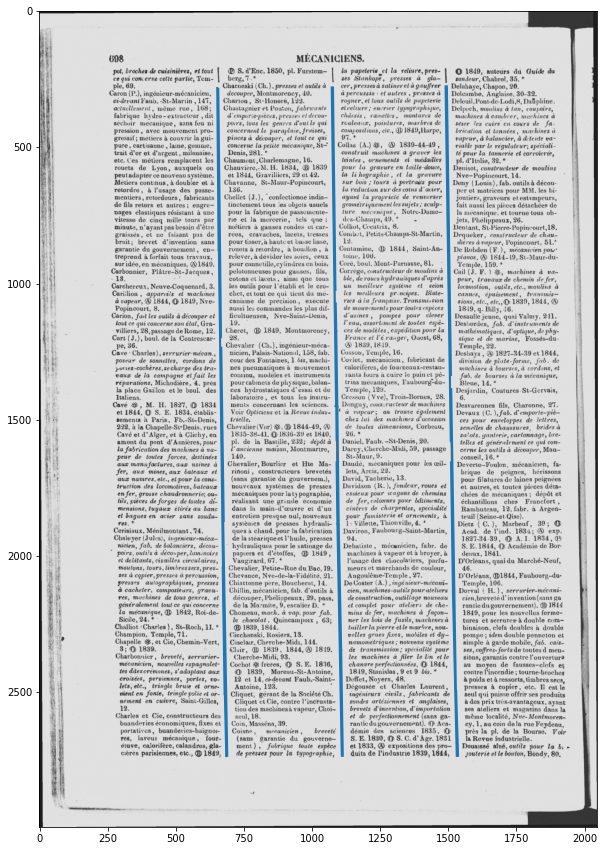

In [4]:
plt.figure(figsize=(10,20))
plt.imshow(in0, cmap="gray")
ax = plt.gca()
for s in segments:
    ax.add_line(plt.Line2D([s.x0, s.x1], [s.y0, s.y1], linewidth=2))

# Deskew

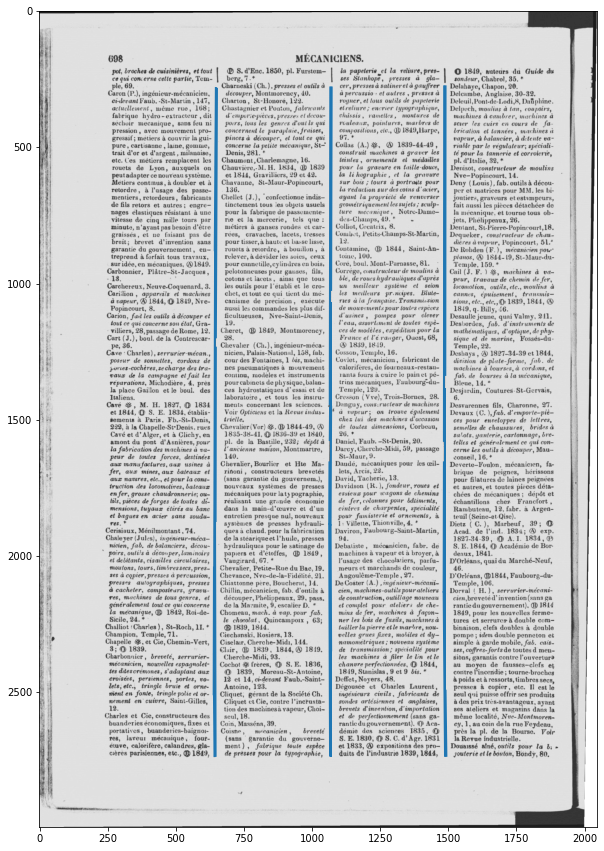

In [5]:
_, segments, deskewed = scribo.deskew(in0, segments, angle_tolerance=5)
plt.figure(figsize=(10,20))
plt.imshow(deskewed, cmap="gray")
ax = plt.gca()
for s in segments:
    ax.add_line(plt.Line2D([s.x0, s.x1], [s.y0, s.y1], linewidth=2))

# Subsampling

In [6]:
import math


def detect_scale(width):
    s = math.log2(2048 / width)
    rs = round(s)
    if abs(s - rs) > 0.2:
        return -1
    return int(rs)

scale = detect_scale(in0.shape[1])

if (scale != 0 and scale != 1):
    raise RuntimeError("Invalid image dimensions. Unable to detect the scale.")

subsampling_ratio = 1
in1 = deskewed

if (scale == 0):
    subsampling_ratio = 0.5
    in1 = scribocxx._subsample(deskewed)
    for s in segments:
        s.scale(subsampling_ratio)


In [7]:
df_segments_dict = App.objectlist_to_dictlist(segments)
pd.DataFrame.from_dict(df_segments_dict)

,angle,length,width,x0,x1,y0,y1
0,89.253593,580.068027,6.515059,322,320,439,1019
1,89.186958,232.047591,6.636975,320,319,1021,1253
2,89.370935,456.038390,7.291771,325,323,142,598
3,89.203774,581.068966,6.248292,533,532,140,721
4,89.161504,112.046543,6.711353,532,531,828,940
5,89.156545,650.091496,6.783209,742,742,138,788
6,89.239969,318.025081,6.340503,323,323,617,935
7,88.638647,113.039378,6.766108,320,321,1254,1367
8,89.031800,430.073788,7.429078,322,323,936,1366
9,89.181137,529.074597,6.514873,745,744,138,667


# Background substraction

In [8]:
fontsize = 20
_em = fontsize * subsampling_ratio
kLineHeight = 1.5 * _em

clean = scribo.background_substraction(in1,
            kMinDiameter = 3.0 * _em,      
            kMinWidth = 4.0 * _em,         
            kMinHeight = 0.5 * kLineHeight,
            kMinGrayLevel = 220,           
            kOpeningRadius = 1.5 * _em,
            debug_prefix="debug-03")

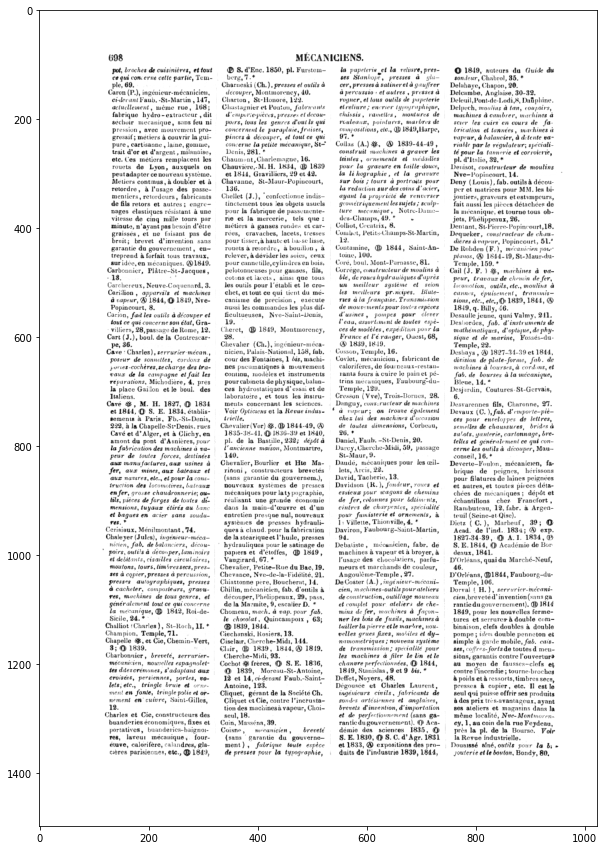

In [9]:
plt.figure(figsize=(10,20))
plt.imshow(clean, cmap="gray")

# XY Cut layout extraction

In [10]:
#FIXME: global variable here
#FIXME: pass the debug variable
config = scribocxx.KConfig(fontsize, scale)
regions = scribo.XYCutLayoutExtraction(clean, segments, config)
regions_df = App.objectlist_to_dictlist(regions)
pd.DataFrame.from_dict(regions_df)

,height,parent_id,type,width,x,y
0,1290,-1,DOMCategory.PAGE,824,122,80
1,16,0,DOMCategory.TITLE_LEVEL_1,824,122,80
2,1267,0,DOMCategory.SECTION_LEVEL_1,824,122,103
3,1267,2,DOMCategory.COLUMN_LEVEL_1,197,122,103
4,1266,3,DOMCategory.SECTION_LEVEL_2,197,122,104
5,1266,4,DOMCategory.COLUMN_LEVEL_2,197,122,104
6,1267,2,DOMCategory.COLUMN_LEVEL_1,203,327,103
7,1267,6,DOMCategory.SECTION_LEVEL_2,203,327,103
8,1267,7,DOMCategory.COLUMN_LEVEL_2,203,327,103
9,1267,2,DOMCategory.COLUMN_LEVEL_1,203,538,103


# Text Line extraction

In [11]:
text_block_indexes, text_blocks = zip(*[ (i, r.bbox) for i,r in enumerate(regions) if r.type  == scribocxx.DOMCategory.COLUMN_LEVEL_2])
text_block_indexes = np.array(text_block_indexes)
ws, lines = scribo.WSLineExtraction(clean, text_blocks, config)
for i, l in enumerate(lines):
    l.parent_id = text_block_indexes[l.parent_id]
    l.ws_label = i + 1

lines_df = App.objectlist_to_dictlist(lines)
pd.DataFrame.from_dict(lines_df)

,height,parent_id,type,width,x,y,ws_label
0,12,5,DOMCategory.LINE,184,134,105,1
1,12,5,DOMCategory.LINE,183,135,119,2
2,12,5,DOMCategory.LINE,39,135,132,3
3,13,5,DOMCategory.LINE,186,127,145,4
4,11,5,DOMCategory.LINE,179,134,160,5
...,...,...,...,...,...,...,...
367,13,14,DOMCategory.LINE,181,762,1303,368
368,13,14,DOMCategory.LINE,184,762,1316,369
369,10,14,DOMCategory.LINE,121,763,1330,370
370,12,14,DOMCategory.LINE,184,757,1343,371


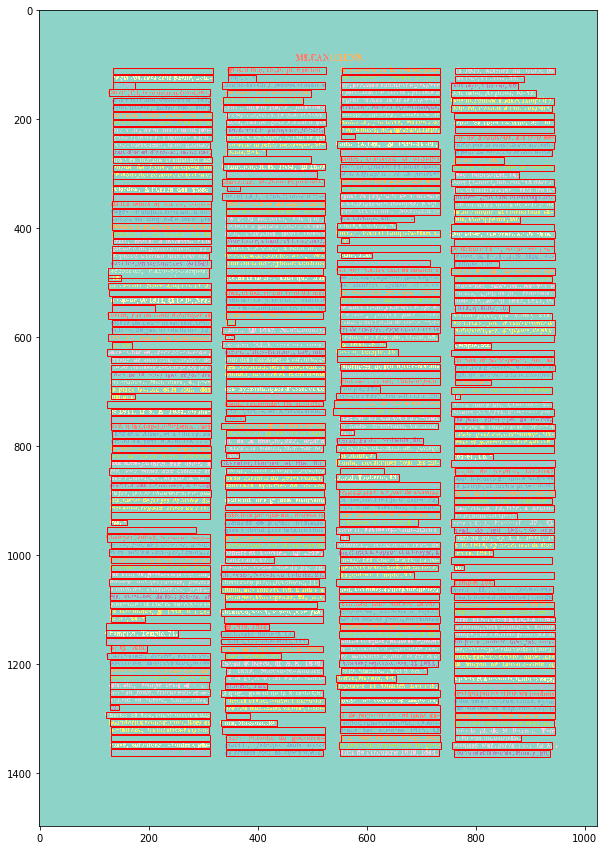

In [12]:
import matplotlib.patches as patches
ncolors = 16
plt.figure(figsize=(10,20))
f = plt.imshow(np.where(clean < 150, 1 + (ws-1) % 15, 0), interpolation="nearest", cmap="Set3")

rects = [ patches.Rectangle((r.x, r.y), r.width, r.height, linewidth=1, edgecolor='r', facecolor="none") for r in lines ]
ax = plt.gca()
for r in rects:
    ax.add_patch(r)

# Rescale data

In [13]:
if subsampling_ratio != 1:
    for r in regions:
        r.bbox.scale(1 / subsampling_ratio)
    for r in lines:
        r.bbox.scale(1 / subsampling_ratio)

# Entry extraction

In [14]:
new_regions = scribo.EntryExtraction(regions, lines)
df = App.objectlist_to_dictlist(new_regions)

pd.DataFrame.from_dict(df)

,height,parent_id,type,width,x,y
0,2580,-1,DOMCategory.PAGE,1648,244,160
1,32,0,DOMCategory.TITLE_LEVEL_1,1648,244,160
2,2534,0,DOMCategory.SECTION_LEVEL_1,1648,244,206
3,2534,2,DOMCategory.COLUMN_LEVEL_1,394,244,206
4,2532,3,DOMCategory.SECTION_LEVEL_2,394,244,208
...,...,...,...,...,...,...
468,26,99,DOMCategory.LINE,362,1524,2606
469,26,99,DOMCategory.LINE,368,1524,2632
470,20,99,DOMCategory.LINE,242,1526,2660
471,24,100,DOMCategory.LINE,368,1514,2686


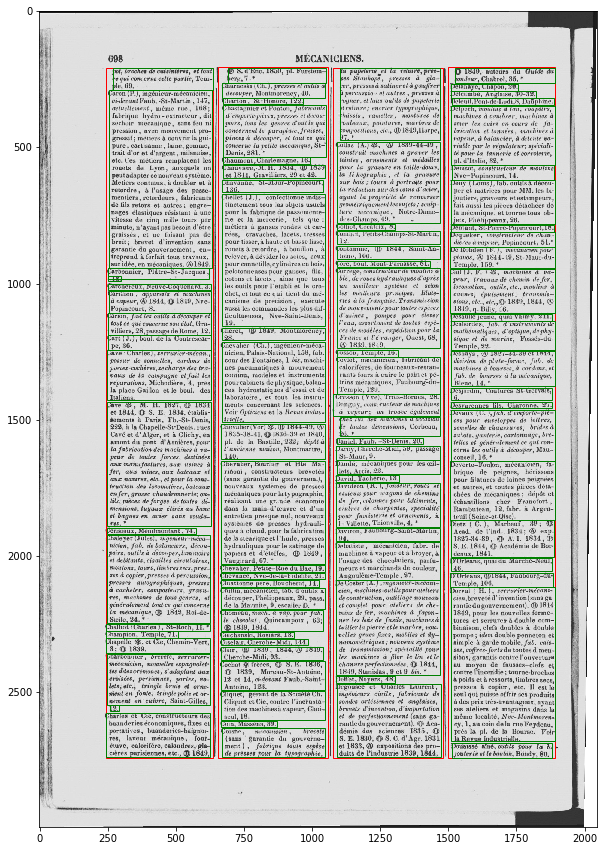

In [15]:
import matplotlib.patches as patches
ncolors = 16
plt.figure(figsize=(10,20))
#f = plt.imshow(np.where(clean < 150, 1 + (ws-1) % 15, 0), interpolation="nearest", cmap="Set3")
f = plt.imshow(deskewed, interpolation="nearest", cmap="gray")

rects = []
for t,c in [(scribocxx.DOMCategory.COLUMN_LEVEL_2,'r'), (scribocxx.DOMCategory.ENTRY, 'g')]:
    entries = (r for r in new_regions if r.type == t)
    rects.extend([ patches.Rectangle((r.x, r.y), r.width, r.height, linewidth=1, edgecolor=c, facecolor="none") for r in entries ])
ax = plt.gca()
for r in rects:
    ax.add_patch(r)

# Run OCR

In [16]:
entries = [ r for r in new_regions if r.type == scribocxx.DOMCategory.ENTRY ]
region_results = app.OCR(deskewed, entries)

Instructions for updating:
non-resource variables are not supported in the long term
pero_eu_cz_print_newspapers_2020-10-07/./ParseNet.pb loaded


2022-01-11 16:31:41.337492: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-01-11 16:31:41.337533: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (yingtan): /proc/driver/nvidia/version does not exist


graph initialized


2022-01-11 16:31:43,441 - INFO - init 'pero ocr engine' performed in 2263.0 ms.


Pretrained layers
[Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), ReLU(inplace=True), Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), ReLU(inplace=True), MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False), Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), ReLU(inplace=True), Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), ReLU(inplace=True), MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False), Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), ReLU(inplace=True), Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), ReLU(inplace=True), Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), ReLU(inplace=True), MaxPool2d(kernel_size=(2, 1), stride=(2, 1), padding=0, dilation=1, ceil_mode=False)]


/home/carlinet/.local/share/virtualenvs/directory-annotator-back-U4GvgQYz/lib/python3.9/site-packages/pero_ocr/layout_engines/layout_helpers.py:183: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  return cascaded_union(triangles)
/home/carlinet/.local/share/virtualenvs/directory-annotator-back-U4GvgQYz/lib/python3.9/site-packages/pero_ocr/document_ocr/crop_engine.py:102: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "reverse_line_mapping" failed type inference due to: non-precise type pyobject
During: typing of argument at /home/carlinet/.local/share/virtualenvs/directory-annotator-back-U4GvgQYz/lib/python3.9/site-packages/pero_ocr/document_ocr/crop_engine.py (104)

File "../../../../home/carlinet/.local/share/virtualenvs/directory-annotator-back-U4GvgQYz/lib/python3.9/site-packages/pero_ocr/document_ocr/crop_engine.py", line 104:
    def reverse_line_mapping(self, forward_map

In [19]:
df = App.objectlist_to_dictlist(entries)
pd.DataFrame.from_dict(df)

,height,parent_id,type,width,x,y,text_ocr,heigth
0,78,5,DOMCategory.ENTRY,368,268,210,"pot, broches de cuisinières, et tout\nce qui c...",78
1,654,5,DOMCategory.ENTRY,378,254,290,"Caron (P.), ingénieur-mécanicien,\nci-devant F...",654
2,38,5,DOMCategory.ENTRY,372,250,944,"Carbonnier, Plâtre-St-Jacques,",38
3,20,5,DOMCategory.ENTRY,48,252,972,L3,20
4,24,5,DOMCategory.ENTRY,376,252,1000,"Carchereux, Neuve-Coquenard, 3.",24
...,...,...,...,...,...,...,...,...
81,134,14,DOMCategory.ENTRY,378,1510,1868,"Dietz (C.), Marbeuf, 39; O\nAcad. de l'ind. 18...",134
82,48,14,DOMCategory.ENTRY,372,1510,2006,"D'Orléans, quai du Marché-Neuf,\n46.",48
83,52,14,DOMCategory.ENTRY,378,1508,2062,"D'Orleans, 01844, Faubourg-du-\nTemple, 106.",52
84,566,14,DOMCategory.ENTRY,382,1510,2114,"Dorval (H.), serrurier-mécani-\ncien, breveté ...",566


# NER

In [21]:
texts = [e.text_ocr for e in entries]
entities = app.NER(texts)

for x, entity in zip(entries, entities):
    x.__dict__.update(entity)


2022-01-11 16:35:20,577 - INFO - NER in 44088.5 ms


In [22]:
df = App.objectlist_to_dictlist(entries)
pd.DataFrame.from_dict(df)

,height,parent_id,type,width,x,y,text_ocr,heigth,addresses,persons,ner_xml
0,78,5,DOMCategory.ENTRY,368,268,210,"pot, broches de cuisinières, et tout\nce qui c...",78,"[{'street_name': 'Tem- ple', 'street_numbers':...",[pot],"<PER>pot</PER>, <ACT>broches de cuisinières, e..."
1,654,5,DOMCategory.ENTRY,378,254,290,"Caron (P.), ingénieur-mécanicien,\nci-devant F...",654,"[{'street_name': 'ci-devant Faub. -St-Martin',...",[Caron (P.],"<PER>Caron (P.</PER>), <ACT>ingénieur-mécanici..."
2,38,5,DOMCategory.ENTRY,372,250,944,"Carbonnier, Plâtre-St-Jacques,",38,"[{'street_name': 'Plâtre-St-Jacques', 'street_...",[Carbonnier],"<PER>Carbonnier</PER>, <LOC>Plâtre-St-Jacques<..."
3,20,5,DOMCategory.ENTRY,48,252,972,L3,20,[],[L3],<PER>L3</PER>
4,24,5,DOMCategory.ENTRY,376,252,1000,"Carchereux, Neuve-Coquenard, 3.",24,"[{'street_name': 'Neuve-Coquenard', 'street_nu...",[Carchereux],"<PER>Carchereux</PER>, <LOC>Neuve-Coquenard</L..."
...,...,...,...,...,...,...,...,...,...,...,...
81,134,14,DOMCategory.ENTRY,378,1510,1868,"Dietz (C.), Marbeuf, 39; O\nAcad. de l'ind. 18...",134,"[{'street_name': 'Marbeuf', 'street_numbers': ...","[Dietz (C.),]","<PER>Dietz (C.),</PER> <LOC>Marbeuf</LOC>, <CA..."
82,48,14,DOMCategory.ENTRY,372,1510,2006,"D'Orléans, quai du Marché-Neuf,\n46.",48,"[{'street_name': 'quai du Marché-Neuf', 'stree...",[D'Orléans],"<PER>D'Orléans</PER>, <LOC>quai du Marché-Neuf..."
83,52,14,DOMCategory.ENTRY,378,1508,2062,"D'Orleans, 01844, Faubourg-du-\nTemple, 106.",52,"[{'street_name': 'Faubourg-du- Temple', 'stree...",[D'Orleans],"<PER>D'Orleans</PER>, <CARDINAL>0184</CARDINAL..."
84,566,14,DOMCategory.ENTRY,382,1510,2114,"Dorval (H.), serrurier-mécani-\ncien, breveté ...",566,"[{'street_name': 'Nve-Montmoren- cy', 'street_...",[Dorval (H.],"<PER>Dorval (H.</PER>), <ACT>serrurier-mécani-..."
